## SAR Asymmetries + Kepert - CASE STUDIES - TO DEBUG

Questions:

- Why the SAR asymmetric amplitude can be greater than Ut? It suggests that K becomes infinite, or C infintely small. Ce the question is: what happens in the equations when C/K is very small? In this case I guess that the BL depth becomes very large, there is almost no friction at the surface (which doesn't mean that the surface is not rough, with huge waves or sea spray); This region will certainly be in between Rmax and R+, in which u is constant. Inside Rmax, u decreases slowly until the center, explaining why Vmin in the SAR data may be greater than the translation speed (Vmin = u_residual_in_the_inner_core + translation speed)

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [93]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / abs(K * ((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * eta(Rs, Vs, K, C, fcor) + 3j * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [(2 + 2j) * (1 + eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)) + 3 * psi(Rs, Vs, K, C, fcor) + 3j * eta(Rs, Vs, K, C, fcor)]
    return num / den

def A1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -eta(Rs, Vs, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(Rs, Vs, fcor)) * psi(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 + 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 - 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

def A_1_prime(Rs, Vs, Ut, K, C, fcor):
    num = -psi(Rs, Vs, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(Rs, Vs, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(Rs, Vs, fcor)) * eta(Rs, Vs, K, C, fcor)]
    den = sqrt_alpha_beta(Rs, Vs, fcor) * [2 - 2j + 3 * (eta(Rs, Vs, K, C, fcor) + psi(Rs, Vs, K, C, fcor)) + (2 + 2j) * eta(Rs, Vs, K, C, fcor) * psi(Rs, Vs, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor):
    '''At the surface (z = 0)'''
    v0 = np.imag(A0(Rs, Vs, K, C, fcor))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, Ut, K, C, fcor)       * np.exp(1j * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, Ut, K, C, fcor)       * np.exp(-1j * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, Ut, K, C, fcor) * np.exp(-1j * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return u_1(THs, Rs, Vs, Ut, K, C, fcor) + u0(Rs, Vs, K, C, fcor) + u1(THs, Rs, Vs, Ut, K, C, fcor)

def v_BL(THs, Rs, Vs, Ut, K, C, fcor):
    '''At the surface (z = 0)'''
    return Vs + v_1(THs, Rs, Vs, Ut, K, C, fcor) + v0(Rs, Vs, K, C, fcor) + v1(THs, Rs, Vs, Ut, K, C, fcor)

# FINAL MODEL
def kepert2001(THs, Rs, Vs, Ut, K, C, fcor):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, Ut, K, C, fcor)
    v_K01   = v_BL(THs, Rs, Vs, Ut, K, C, fcor)  

    # Adds the translation speed
    Utu     = Ut * np.cos(THs) # Radial component of Ut
    Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # Utu = Utv = 0
    
    return u_K01 + Utu, v_K01 + Utv

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., 0., 0.1], [upper_bound, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K01, v_K01 = kepert2001(THs, Rs, Vs_try, Ut, K, C, fcr) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K01, v_K01)

    # Compute asymmetries on Kepert wind field
    aks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, _, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
    
    return aks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette      = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [81]:
#########################
###  HYPERPARAMETERS  ###
#########################
# Reference grids
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

In [82]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/results/sar_extended/03_addIBT/dsg.nc',
    'sar_dir':  '/home/arthur/data/cyclobs/RCM/sar_files/',
    'sav_dir': '/home/arthur/results/winddirection/00_SAR_AND_KEPERT_ASYM/',
}

In [83]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [84]:
### FILTERS
# TODO: Remove Southern Hemisphere storms? 
filters = {
    'correct_center': (dsg.center_quality_flag < 2),
    'uncropped'     : (dsg.percent_outside < 5),
    'tropical_lat'  : (abs(dsg.lat) < 30),
    'strong_storm'  : (dsg.vmx >= 33),
    'small_rmx'     : (dsg.rmx <= 100000),
    'far_from_coast': (dsg.dist2coast >= dsg.r0),   
}

kept_storms = np.logical_and.reduce([filters[e] for e in filters.keys()])
dsg['keep'] = xr.DataArray(
    data=kept_storms,
    coords={'time': dsg.time}
)

dsg_valid = dsg.where(dsg.keep, drop=True)

In [85]:
# CASE STUDY
# p    = 'rs2--owi-ca-20151021t152606-20151021t152722-00003-______sw_ep192015_cyclone_polar.nc'
# p    = 'rs2--owi-ca-20150805t211206-20150805t211322-00003-______sw_wp132015_cyclone_polar.nc'
p    = 's1a-ew-owi-ca-20160831t031520-20160831t031712-000003-014425_sw_ep132016_cyclone_polar.nc'
dsgv = dsg_valid.where(dsg_valid.file_tcva == p, drop=True)

  0%|          | 0/1 [00:00<?, ?it/s]

0 s1a-ew-owi-cm-20160831t031520-20160831t031712-000003-014425_sw.nc


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

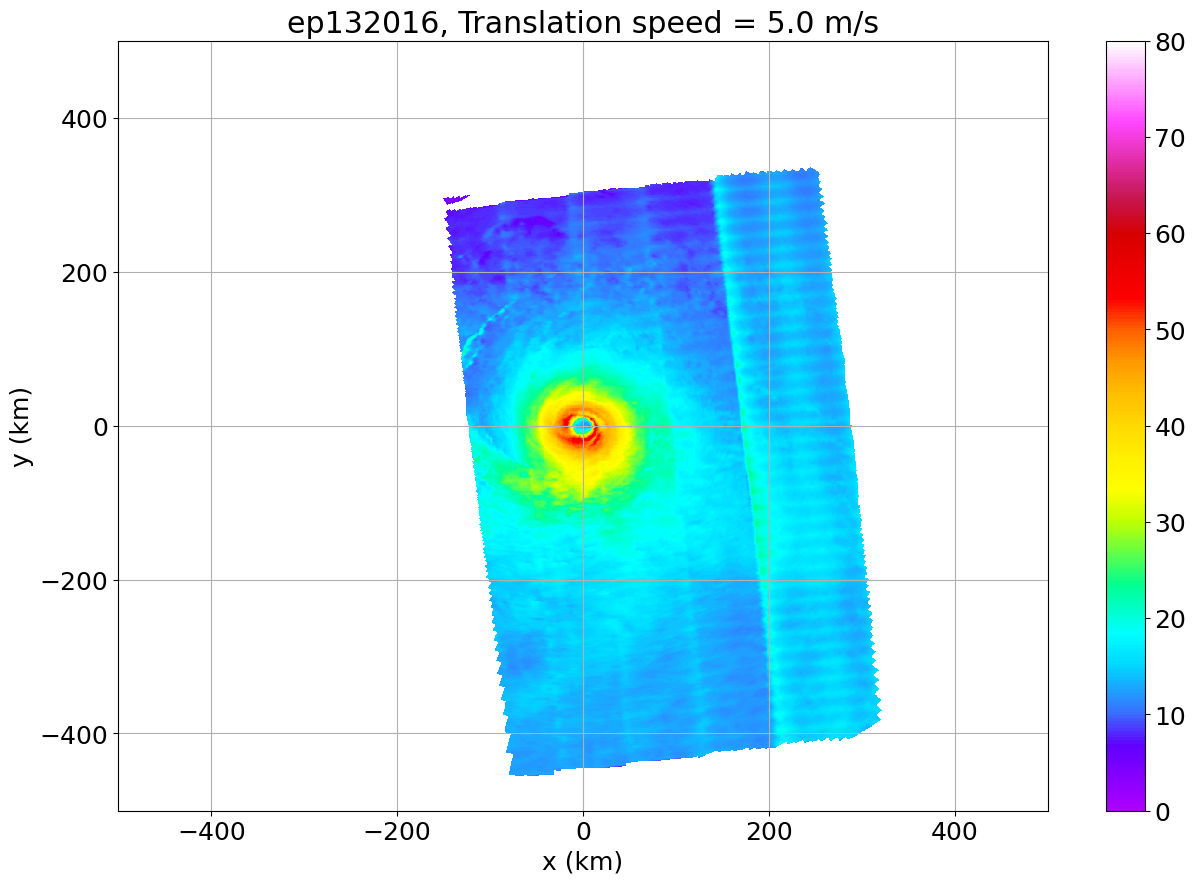

  0%|          | 0/1 [00:00<?, ?it/s]

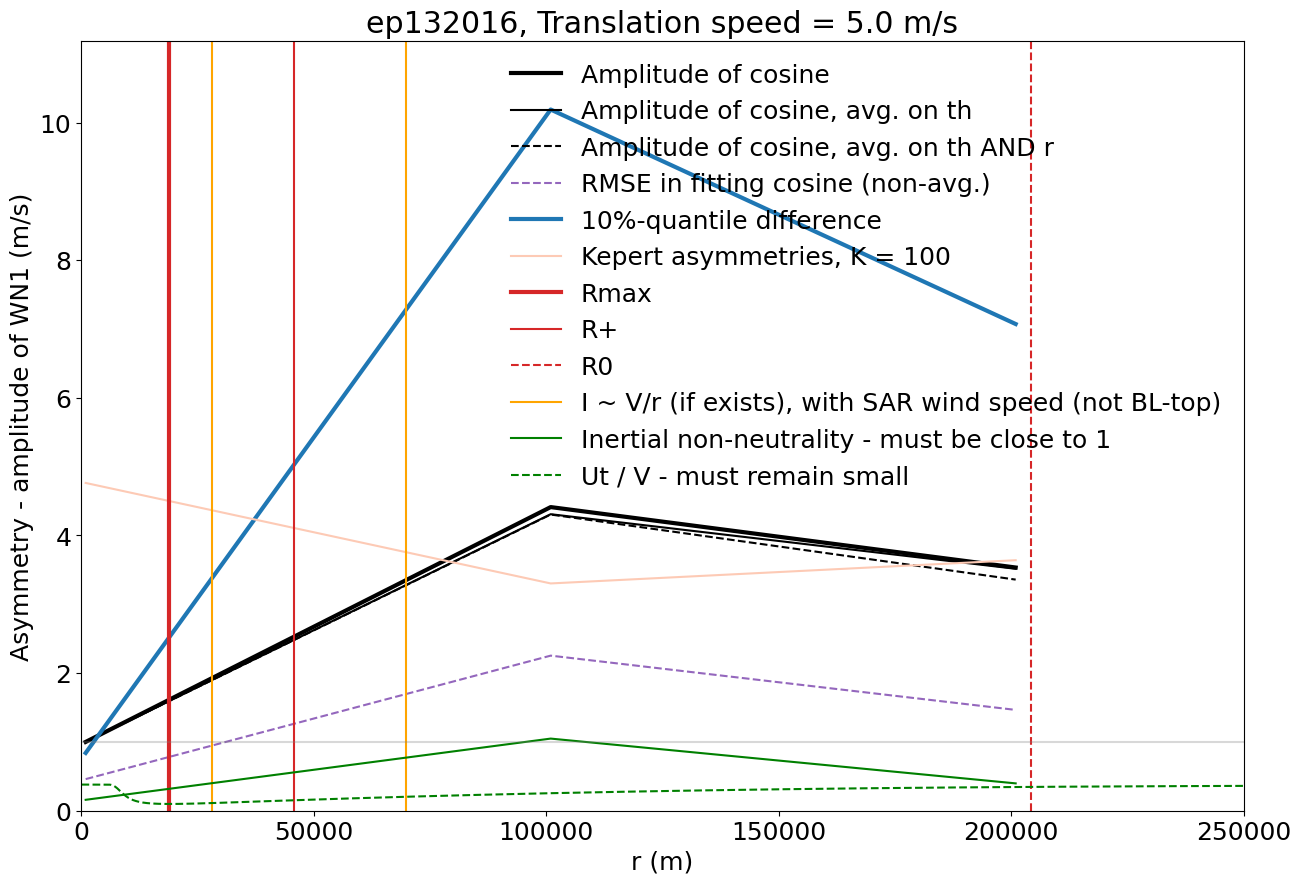

In [140]:
# Parameters
C  = 1.5e-3             # fixed
# Ks = [1, 50, 100, 150] # trial
Ks = [100]
# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

# Iterate
for t in tqdm(range(len(dsgv.time))):
    # Open file
    ds  = dsgv.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)
    
    # Fixed parameters
    vmx = float(ds.vmx_hol)
    rmx = float(ds.rmx_hol)
    vmn = float(ds.vmn_hol)
    B   = float(ds.B_hol)
    lat = float(ds.lat)
    fcr = abs(float(ds.fcor))
    Ut  = float(ds.speed)

    # Holland with fixed parameters
    V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
    Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

    # I ~ V/r radii
    try:
        I_Vr         = (I(Rs, Vs, fcr) - Vs / rs)[0, :]    # I - V/r
        r_stt, r_end = rs[I_Vr <= 0][0], rs[I_Vr <= 0][-1] # Define the bounds
    except IndexError:
        r_stt = r_end = np.nan

    # Prepare averagings
    timescale   = 1 / I(Rs, Vs, fcr)[0, :]             # time needed for the BL to develop
    radialscale = timescale * Vs[0, :] / 5             # radial distance travelled by an air parcel in the meantime, considering that U/V = 5
    tangenscale = timescale * Vs[0, :]                 # tangential distance travelled by an air parcel in the meantime
    thetascale  = 360 * tangenscale / (2 * np.pi * rs) # convert this tangential distance to theta
    thetascale[np.isnan(thetascale)] = 9999            # # happens when time 1/I explodes, so put a high value to enter the ValueError exception below (AS2 and AS3 computation)

    print(t, ds.file.item())

    # x-axis
    # xs = np.linspace(ds.rmx, 2 * ds.rps, 50)
    # xs = np.linspace(ds.rmx, 2 * ds.rps, 10)
    # xs = np.linspace(1000, 250000, 250)[::100]
    xs = np.linspace(1000, 250000, 250)[::100]
    
    # Asymmetries
    ASS  = []
    AS2  = []
    AS3  = []
    ASQ  = []
    rads = []
    ERR  = []
    for rad in tqdm(xs):
        try:
            # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
            # ass, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx))
            valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
            ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
            error         = float(rmse(wn1(np.deg2rad(valid_dsp.theta), ass, phi, c), valid_dsp.wind_speed)) 
            ASS.append(ass)
            ERR.append(error)

            # Preparing averagings
            avg_on_u = radialscale[rs >= rad][0]
            avg_on_v = int(thetascale[rs >= rad][0])

            try:
                # Average on theta
                valid_dsp2      = dsp.sel(rad=rad, method='nearest').rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(subset=['wind_speed'], dim='theta')
                as2, phi2, c2   = get_wn1(np.deg2rad(valid_dsp2.theta), valid_dsp2.wind_speed, float(ds.vps), float(ds.vmx))
                AS2.append(as2)

                # Average on theta AND r
                valid_dsp3      = dsp.sel(rad=slice(rad - avg_on_u, rad + avg_on_u))[['wind_speed']].mean(dim='rad', skipna=True).rolling(theta=avg_on_v, center=True, min_periods=2).mean().dropna(dim='theta')
                as3, phi3, c3   = get_wn1(np.deg2rad(valid_dsp3.theta), valid_dsp3.wind_speed, float(ds.vps), float(ds.vmx))
                AS3.append(as3)
                
            except ValueError:
                # happens when time 1/I explodes, such that to average on theta we would average on more than 361 values of theta!
                as2 = as3 = np.nan
                AS2.append(as2)
                AS3.append(as3)

            # Add radius
            rads.append(rad)

        except RuntimeError:
            break
        # Asymmetries with the quantiles
        a_qtl = dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.9) - dsp.sel(rad=rad, method='nearest').wind_speed.quantile(0.1)
        ASQ.append(a_qtl)
        
    # Inertial neutrality?
    dr                 = np.diff(Rs[0, :])[0] # meteRs
    dM_dr              = Vs + Rs * np.gradient(Vs, dr, axis=1) + fcr * Rs
    beta               = dM_dr[0, :] / rs
    idxs               = np.searchsorted(rs, xs)
    first_term_eq5_k01 = (Vs[0, idxs] / rs[idxs]) * (np.array(AS3) / (2 * np.pi))
    
    # Kepert model
    AKS = dict.fromkeys(Ks)
    for i, K in enumerate(tqdm(Ks)):
        aks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, Ut, K, C, fcr, xs)
        AKS[K]       = aks

    ### Plot
    # First save the SAR image
    dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
    ds_x, ds_y   = pol2cart(dr, th)
    ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')

    plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
    plt.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer);plt.colorbar()
    plt.xlabel('x (km)');plt.ylabel('y (km)')
    plt.grid()

    plt.show()
    # plt.savefig(PTHS['sav_dir'] + ds.file.item().item().split('.')[0] + '_2Dwindfield', bbox_inches='tight', format='png');plt.clf()

    # Then plot the SAR asymmetry profiles
    plt.plot(rads, ASS, c='k',          linewidth=3,        label='Amplitude of cosine')
    plt.plot(rads, AS2, c='k',                              label='Amplitude of cosine, avg. on th')
    plt.plot(rads, AS3, c='k',          linestyle='dashed', label='Amplitude of cosine, avg. on th AND r')
    plt.plot(rads, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
    plt.plot(rads, ASQ, c='tab:blue',   linewidth=3,        label='10%-quantile difference')
    # Kepert asymmetry profiles
    for i, K in enumerate(tqdm(Ks)):
        plt.plot(xs, AKS[K], c=colors[i], label='Kepert asymmetries, K = {}'.format(K))
    # Wind radii
    plt.axvline(ds.rmx, c='tab:red',    linewidth=3,        label='Rmax')
    plt.axvline(ds.rps, c='tab:red',    label='R+')
    plt.axvline(ds.r0,  c='tab:red',    linestyle='dashed', label='R0')
    # I ~ V/r
    plt.axvline(r_stt,  c='orange',                         label='I ~ V/r (if exists), with SAR wind speed (not BL-top)')
    plt.axvline(r_end,  c='orange')
    # Validity curves
    plt.plot(rs[idxs], first_term_eq5_k01 / beta[idxs], c='green',                     label='Inertial non-neutrality - must be close to 1')
    plt.plot(rs, float(ds.speed) / Vs[0, :],            c='green', linestyle='dashed', label='Ut / V - must remain small')
    plt.axhline(1, c='gray', alpha=0.3)
    # Legends
    plt.xlabel('r (m)')
    plt.ylabel('Asymmetry - amplitude of WN1 (m/s)')
    plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
    plt.legend(frameon=False, loc='upper right')
    plt.xlim(0, max(float(ds.r0) + 5000, 250000))
    plt.ylim(0, 1 + float(max(max(ASQ), max(ASS))))

    # ### Save
    # plt.savefig(PTHS['sav_dir'] + ds.file.item().item().split('.')[0] + '_asym', bbox_inches='tight', format='png');plt.clf()

4.568684702638418
3.3992442575509365


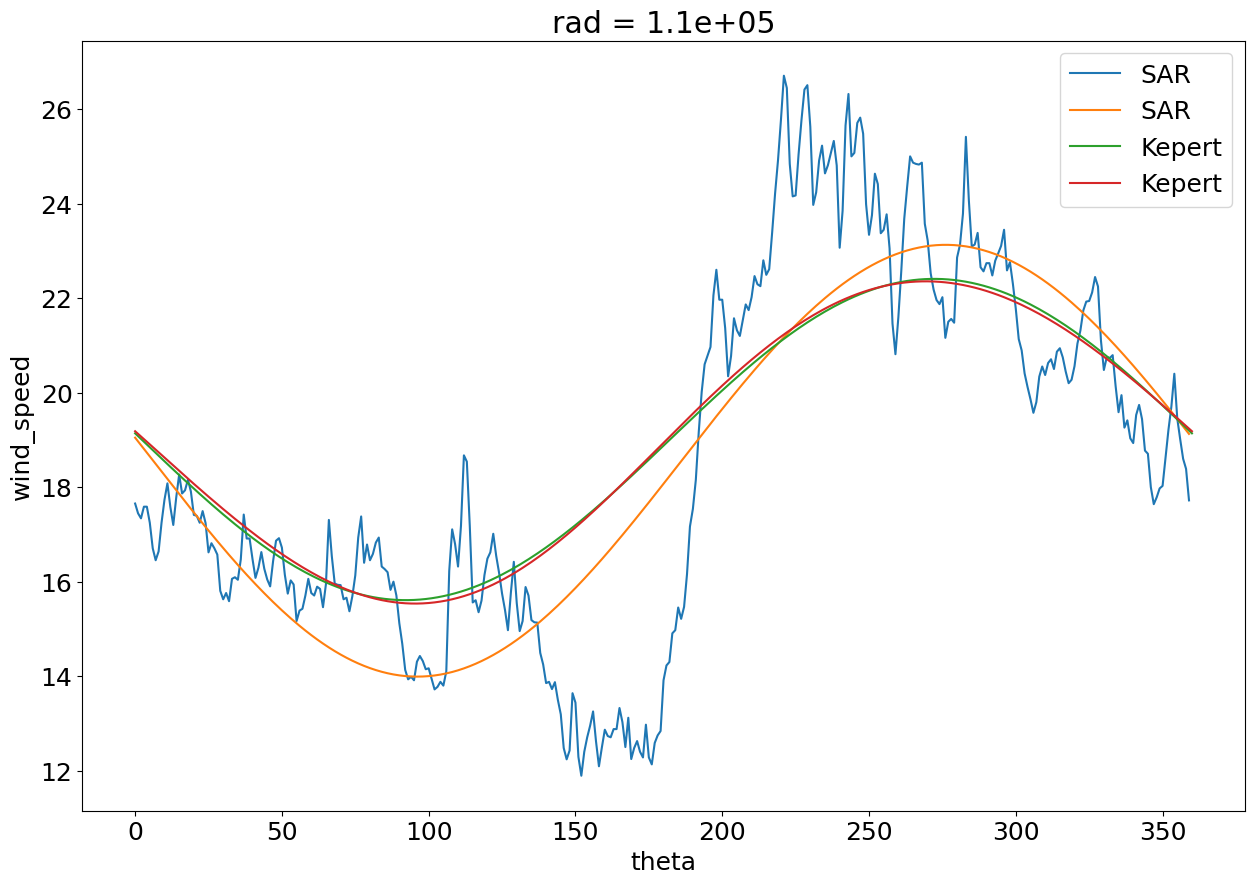

In [165]:
rad = 110000

valid_dsp     = dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta')
ass, phi, c   = get_wn1(np.deg2rad(valid_dsp.theta), valid_dsp.wind_speed, float(ds.vps), float(ds.vmx))
valid_dsp.wind_speed.plot(label='SAR')
wn1(np.deg2rad(valid_dsp.theta), ass, phi, c).plot(label='SAR')

ak, phik, ck  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
plt.plot(kep_pol.theta, wn1(np.deg2rad(kep_pol.theta), ak, phik, ck), label='Kepert')
kep_pol.wind_speed.sel(rad=rad, method='nearest').plot(label='Kepert')

plt.legend()

print(ass)
print(ak)

(-150.0, 150.0)

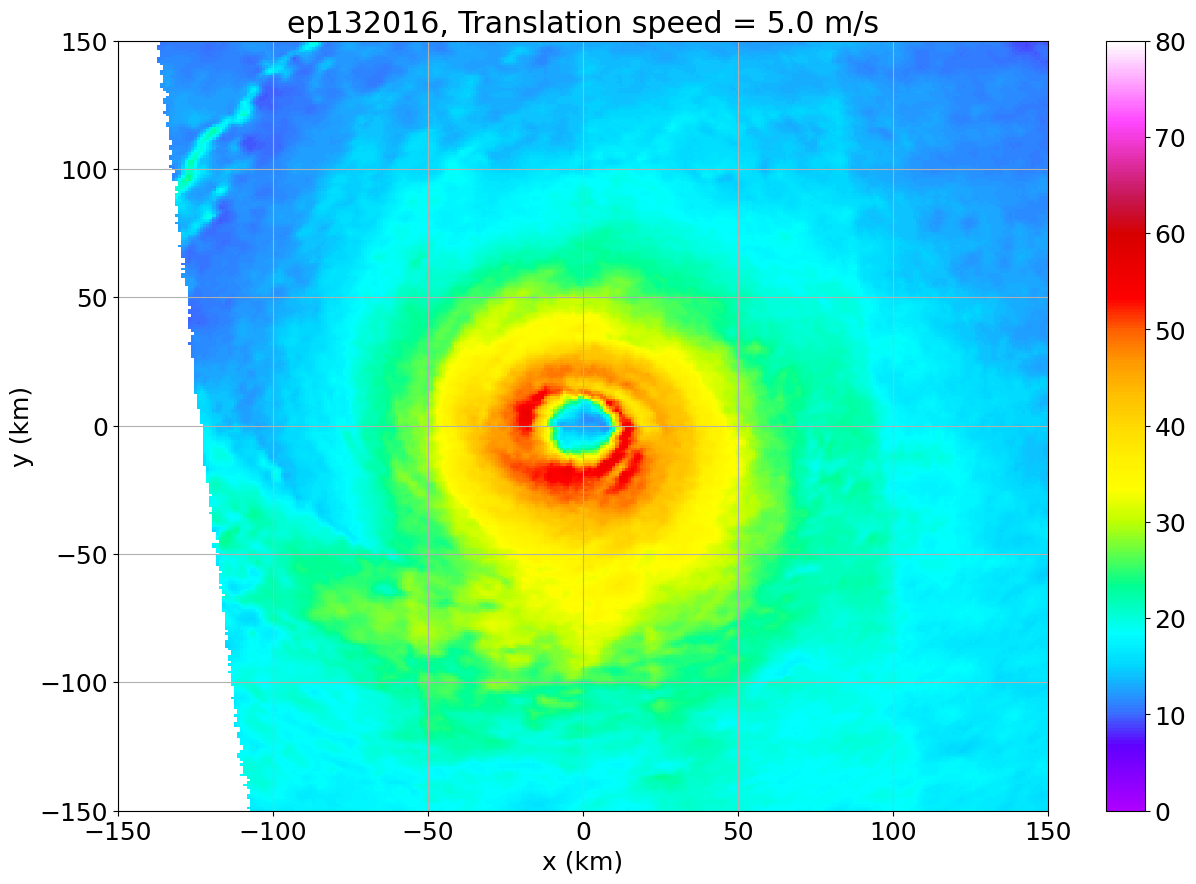

In [168]:
### Plot
# First save the SAR image
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')

plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
plt.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer);plt.colorbar()
plt.xlabel('x (km)');plt.ylabel('y (km)')
plt.grid()
plt.xlim(-150, 150)
plt.ylim(-150, 150)

(-100.0, 100.0)

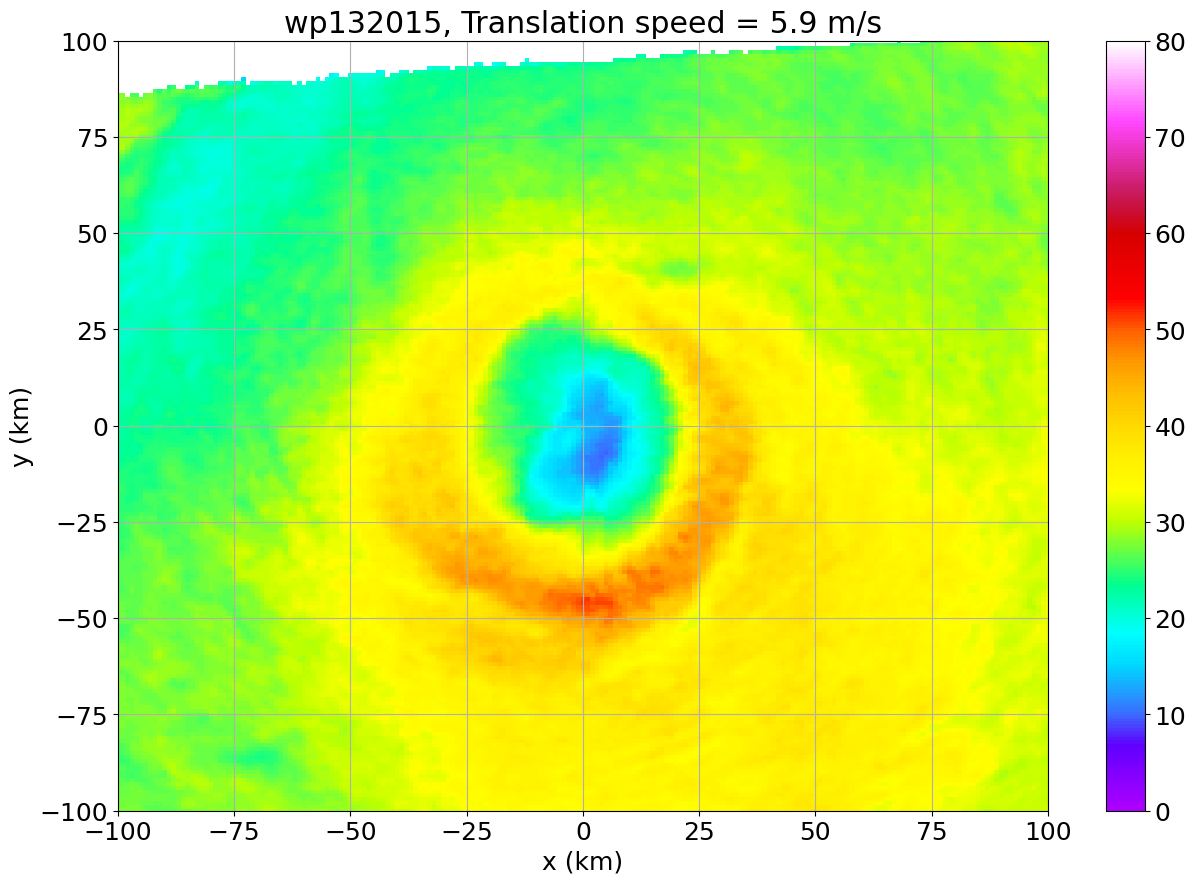

In [54]:
### Plot
# First save the SAR image
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')

plt.title('{}, Translation speed = {:.1f} m/s'.format(ds.id.item(), ds.speed))
plt.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer);plt.colorbar()
plt.xlabel('x (km)');plt.ylabel('y (km)')
plt.grid()
plt.xlim(-100, 100)
plt.ylim(-100, 100)

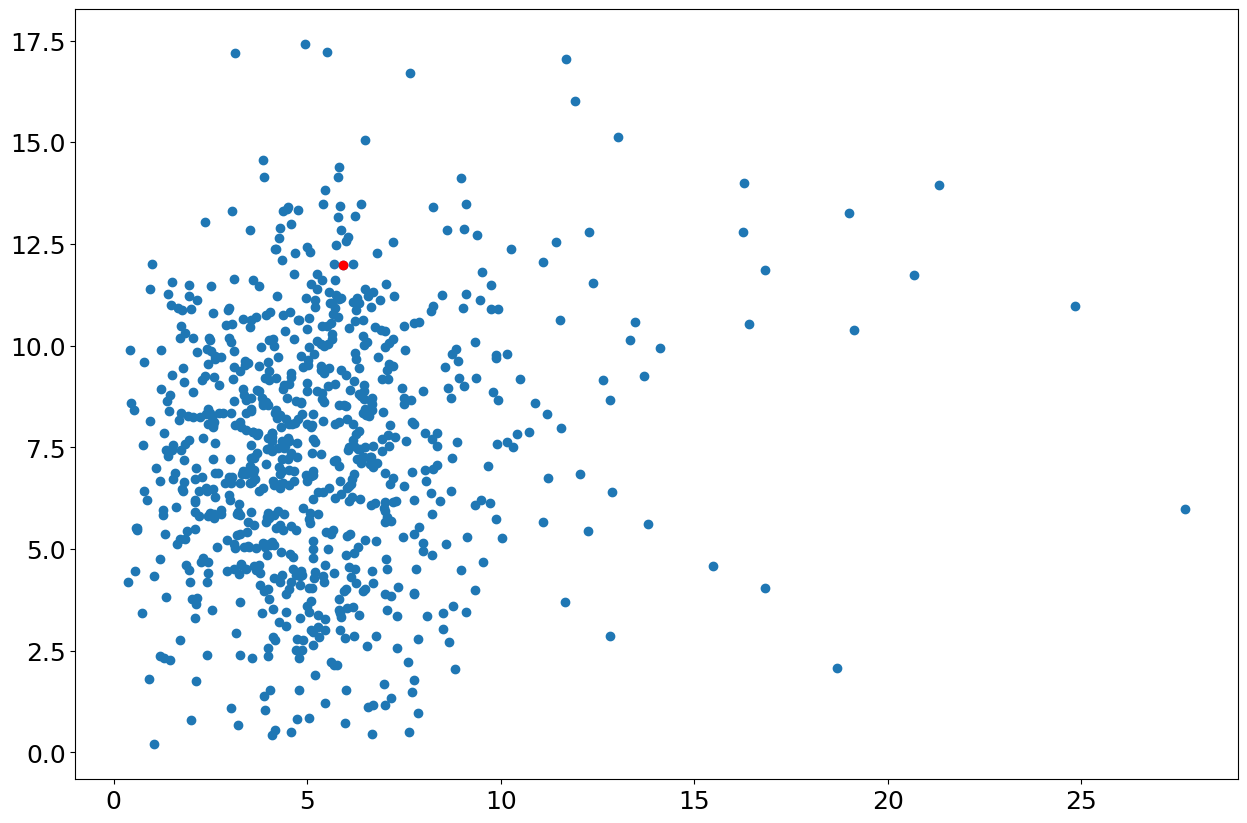

In [64]:
plt.scatter(dsg.speed, dsg.vmn)
plt.scatter(ds.speed,  ds.vmn, c='r')

In [65]:
### QUESTIONS
# why I~V/r don't correspond to locations where the asymmetries drop in Kepert?
# SOLVED
# rs2--owi-cm-20150805t211206-20150805t211322-00003-______sw_asym

# They still don't correspond exactly to it:
# s1a-ew-owi-cm-20160831t031520-20160831t031712-000003-014425_sw_asym
# Because I compute them on Vs, and not on Vs_try;
# If I wanted to do it correctly, I should compute them on each Vs_try for each value of K. So no.

# why Kepert asymmetries are so small for some cases?
# rs2--owi-cm-20151021t152606-20151021t152722-00003-______sw_asym